In [1]:
import pandas as pd
import numpy as np
from bff_processor.Systogram import Systogram
from bff_processor.bff_meta import *
from bff_processor.sig_op_func import *
from bff_processor.bff_cuts import bff_1, bff_2, reg_filter
from bff_processor.plotting_utils import unc_plot, boost2unc
from bff_processor.utils import nratio_plot_template, hist2unc, vunc2nom, chiSquared
import os
import re
from time import perf_counter
import boost_histogram as bh
import pyarrow.feather as feather
import zfit
from zfit import z
from math import pi
import mplhep as hep
hep.set_style(hep.style.CMS)
plt.rcParams.update({
    "text.usetex": True,
})
from zfit.models.physics import DoubleCB

/home/ryan/Develop/Physics/bff_plotting_code_v3/env/lib/python3.8/site-packages/zfit/__init__.py:48: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


In [2]:
import pickle

In [3]:
from zfit.models.physics import double_crystalball_func
class DoubleCBError(zfit.pdf.ZPDF):
    _N_OBS = 2
    _PARAMS = ['mu_mass', 'b_mass', 'sigma_mass', 'sigma_b'
               ,'alphal', 'alphar',
              'nl', 'nr']
        
    def uncertainty(self, x):
        import uncertainties.unumpy as unp
        from uncertainties import ufloat
        y = self.pdf(x) 
        return np.asarray([ufloat(yval,0) for yval in y])  
    
    def _unnormalized_pdf(self, x):  # implement function
        data, mass = z.unstack_x(x)
        mu_mass = self.params['mu_mass']
        b_mass = self.params['b_mass']
        sigma_mass = self.params['sigma_mass']
        sigma_b = self.params['sigma_b']
        alphal = self.params['alphal']
        alphar = self.params['alphar']
        nl = self.params['nl']
        nr = self.params['nr']
        mu = mu_mass*mass + b_mass
        sigma = sigma_mass*mass + sigma_b
        return double_crystalball_func(data,mu=mu, sigma=sigma, alphal=alphal, alphar=alphar, nl=nl, nr=nr)
        
        

In [4]:
try:
    mu_mass = zfit.Parameter("mu_mass", 1,  0, 2)
    b_mass = zfit.Parameter("b_mass", 0,  -1, 1)
    sigma_mass = zfit.Parameter("sigma_mass", 0.06,  .00, 1)
    sigma_b = zfit.Parameter("sigma_b", 5,  -20, 20)
    alphal = zfit.Parameter("alphal", 2,  0, 100)
    nl = zfit.Parameter("nl", 3,  -10, 10)
    alphar = zfit.Parameter("alphar", 40,  0, 100)
    nr = zfit.Parameter("nr", 10,  -100, 100)
    Nsig = zfit.Parameter("Nsig", 1., -20., 1e8)
except:
    print("already defined")

In [66]:
sigma_mass.set_value(.5)
alphal.set_value(1.4)
nl.set_value(2.6)
alphar.set_value(1.6)
nr.set_value(40)

In [ ]:
0.0261814 , -2.12139535
alphal    1.167       False
alphar    1.672       False
nl         2.66       False
nr        4.074       False

In [188]:
sigma_mass.set_value(.03)

In [217]:
x = zfit.Space("x", limits=[110,800])
m = zfit.Space("mass", limits=[100,800])
obs=x*m
doublecb = DoubleCBError(obs=obs, mu_mass=1, b_mass=0,
                             sigma_mass=0.0261814, sigma_b=sigma_b,
                             alphal=1.167, nl=2.66, alphar=1.672, nr=4.074)


In [218]:
era = 2016
df = feather.read_feather('data/combined_{}.feather'.format(era))

In [219]:
bff_data = df[df.name.str.contains("BFF")]
data = bff_data[(bff_data.mass>125) & (bff_data.dbs==0.04)][['DiLepMass','mass']].to_numpy()
weights = bff_data[(bff_data.mass>125) & (bff_data.dbs==0.04)]['Weight']

In [220]:
data = zfit.Data.from_numpy(obs=obs, array=data, weights=weights)

In [221]:
nll = zfit.loss.UnbinnedNLL(model=doublecb, data=data)

/home/ryan/Develop/Physics/bff_plotting_code_v3/env/lib/python3.8/site-packages/zfit/util/cache.py:279: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return all(np.equal(self.immutable_representation, other.immutable_representation))


In [222]:
minimizer = zfit.minimize.Minuit()

In [223]:
result = minimizer.minimize(nll)

In [224]:
doublecb.result = result

In [225]:
result

FitResult of
<UnbinnedNLL model=[<zfit.<class '__main__.DoubleCBError'>  params=[FIXED_autoparam_89, FIXED_autoparam_90, FIXED_autoparam_91, FIXED_autoparam_92, FIXED_autoparam_93, FIXED_autoparam_94, FIXED_autoparam_95, sigma_b]] data=[<zfit.core.data.Data object at 0x7f2dd9e3b070>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 9.6e-07 │ 711.3       │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name       value    at limit
-------  -------  ----------
sigma_b     0.79       False

In [226]:
data = np.array([np.linspace(100,800, 100), np.full(100, 250)]).T
y = doublecb.pdf(data)
data = np.array([np.linspace(100,800, 100), np.full(100, 500)]).T
y500 = doublecb.pdf(data)

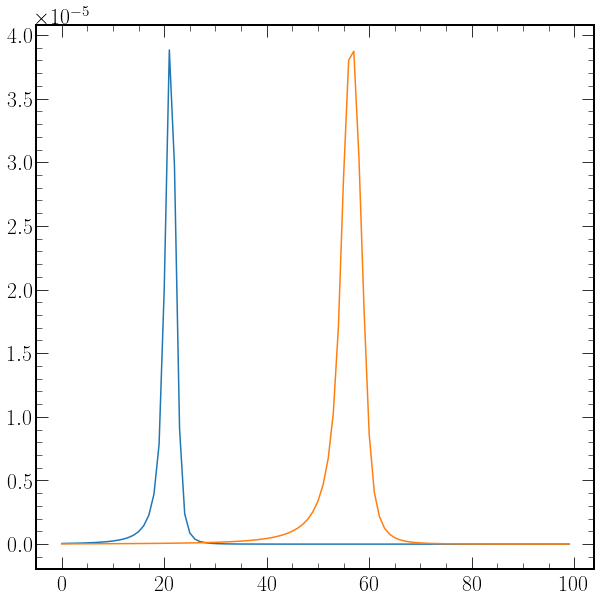

In [227]:
plt.plot(y)
plt.plot(y500)

2456.847002375406 2456.847002375406


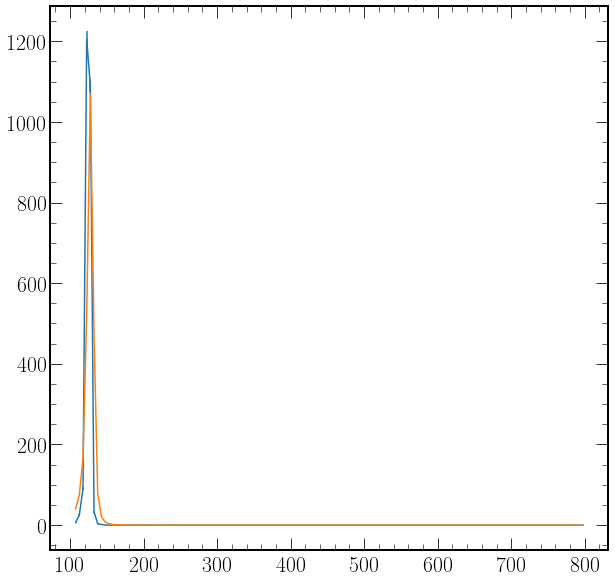

3007.053268602648 3007.053268602649


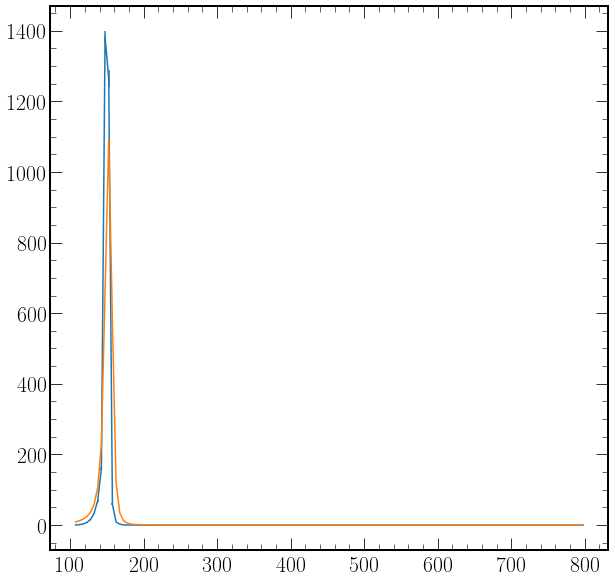

2562.6780003938043 2562.6780003938043


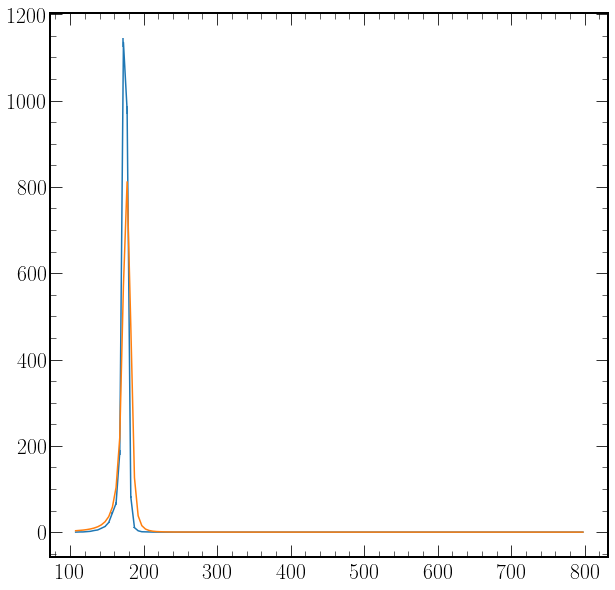

1881.2358326974165 1881.2358326974165


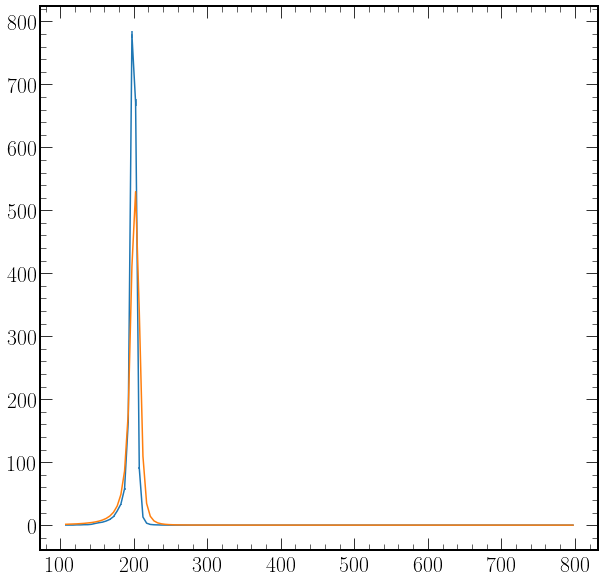

3546.4112462669773 3546.411246266977


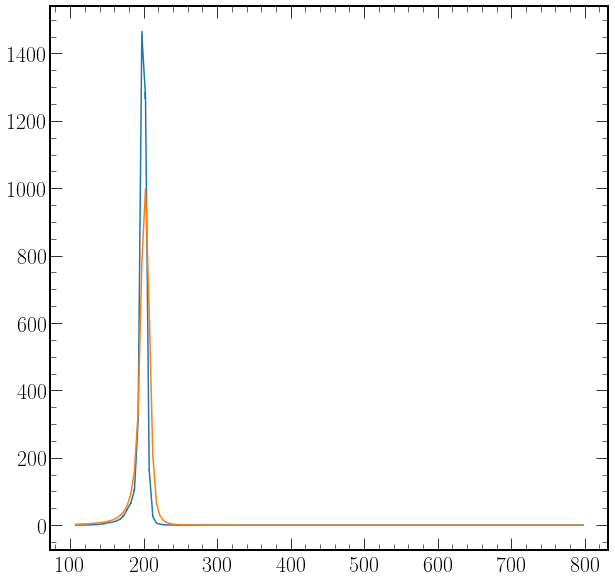

8493.181698532653 8493.181698532655


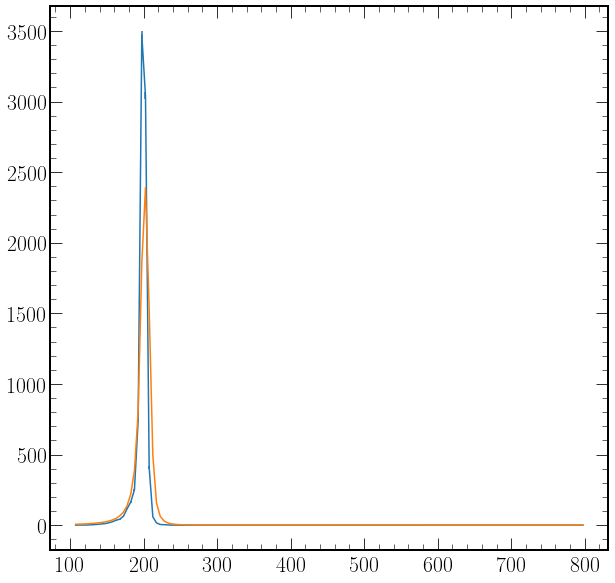

971.9046604987647 971.9046604987645


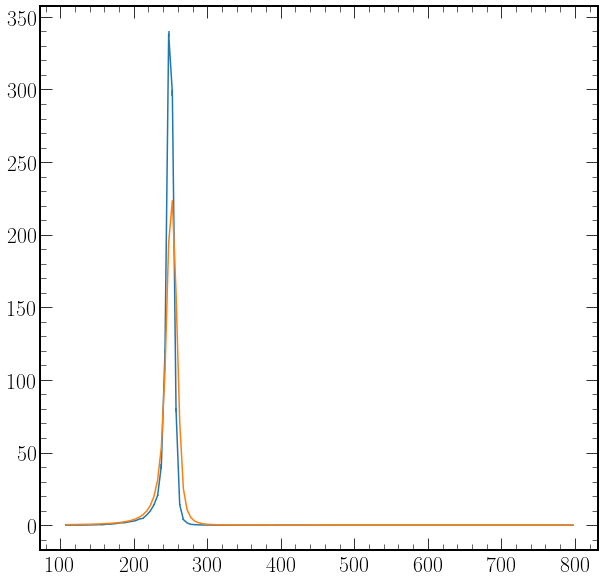

520.8154750095542 520.8154750095541


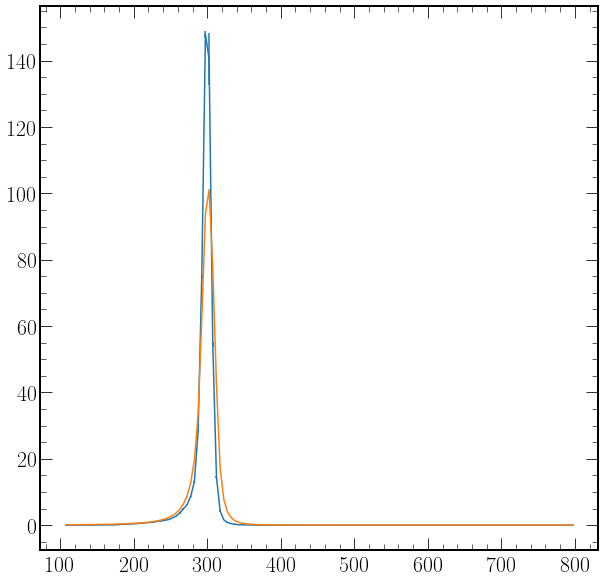

275.1033339788279 275.10333397882783


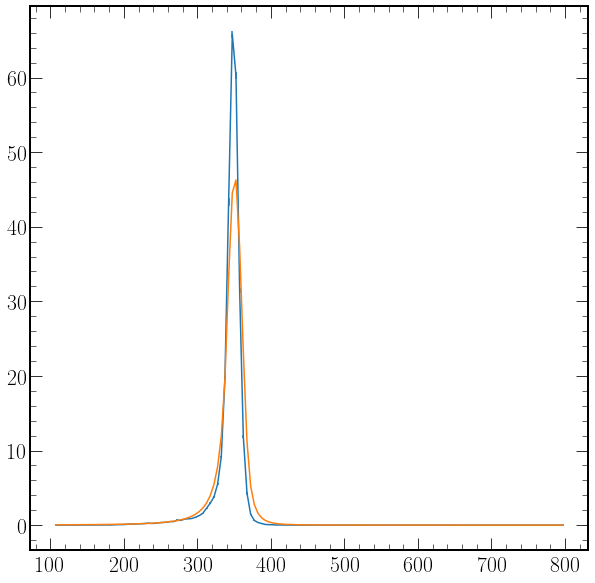

540.6787962568596 540.6787962568596


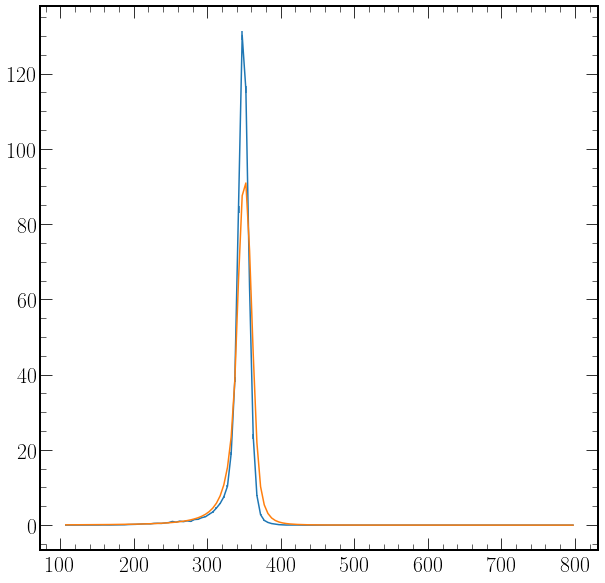

1314.8608898281448 1314.8608898281448


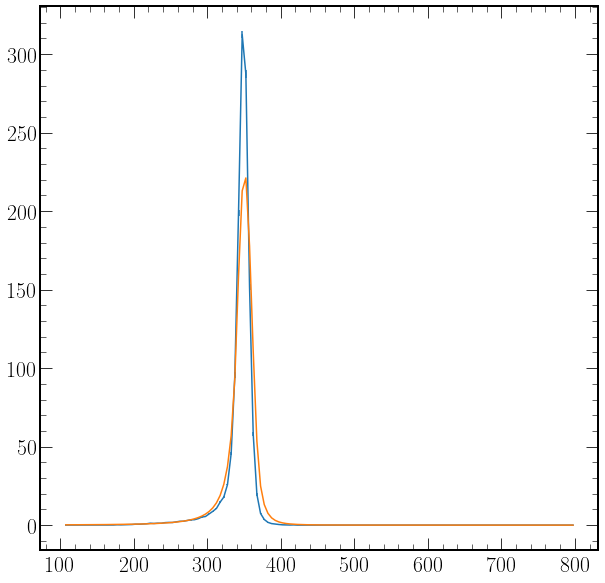

148.37100532069041 148.37100532069044


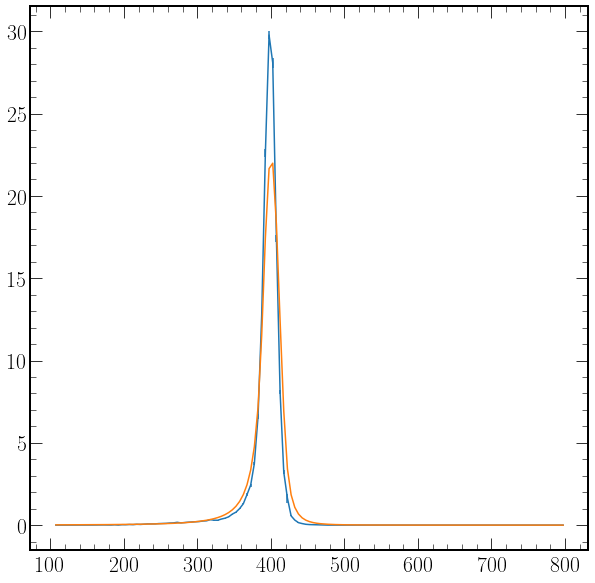

47.64328675951041 47.6432867595104


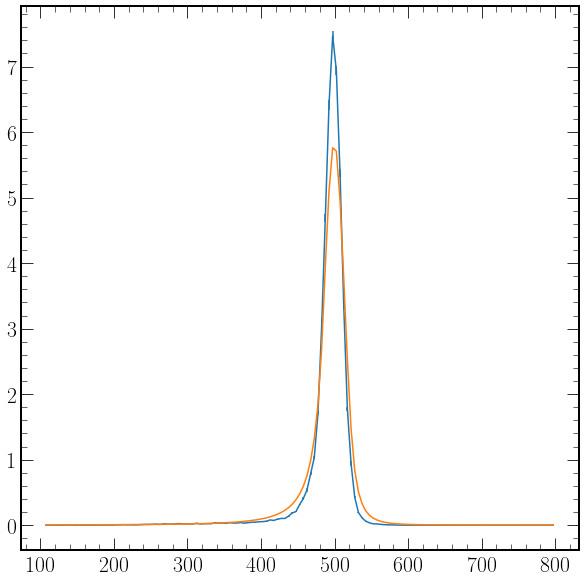

96.92433135737122 96.92433135737122


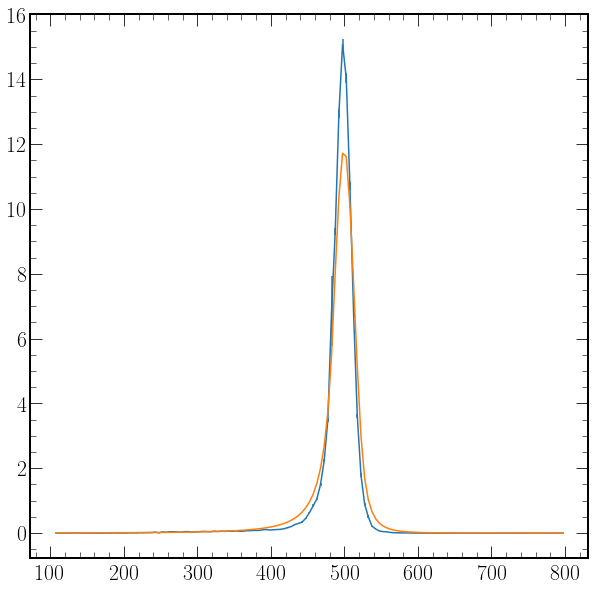

240.77008174921858 240.77008174921855


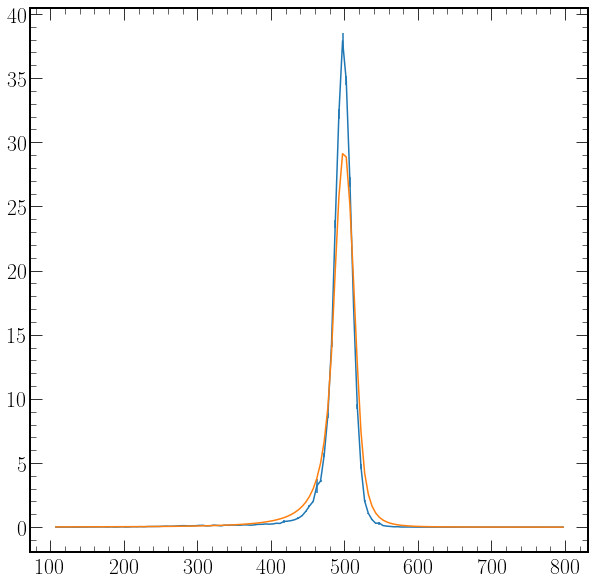

In [228]:
fig, ax = plt.subplots()

for name in np.unique(bff_data.name):
    dmass = bff_data[bff_data.name==name]['DiLepMass']
    mass = bff_data[bff_data.name==name]['mass'].iloc[0]
    weight =  bff_data[bff_data.name==name]['Weight']
    
    x_mass = np.array([np.linspace(105,800, 139), np.full(139, mass)]).T
   
    hist = bh.Histogram(bh.axis.Regular(139,105,800), storage=bh.storage.Weight())
    hist.fill(dmass, weight=weight)
    centers= hist.axes[0].centers
    n_bins = len(centers)
    plot_scaling = np.sum(weight) / n_bins * x.area()
    
    
    plt.errorbar(centers, hist.values(), yerr=hist.variances()**.5, label=name,zorder=1)
    y = doublecb.pdf(x_mass) * plot_scaling
    y = y/np.sum(y)*np.sum(hist.values())
    print(np.sum(y), np.sum(hist.values()))
    plt.plot(centers,y)
    #plt.legend()
    plt.show()
    

In [ ]:
def fit_lognorm(y, weights, obs, verbose=False):
    mu.set_value(np.mean(y))
    doublecb = DoubleCBError(obs=obs, mu_mass=mu_mass, b_mass=b_mass,
                             sigma_mass=sigma_mass, sigma_b=sigma_b,
                             alphal=alphal, nl=nl, alphar=alphar, nr=nr).create_extended(Nsig)
    # load the data
    data = zfit.Data.from_numpy(obs=obs, array=y, weights=weights)
    
    # build the loss
    nll = zfit.loss.ExtendedUnbinnedNLL(model=doublecb, data=data)
    
    # minimize
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    doublecb.result = result
    
    # calculate errors
    #param_errors = result.hesse()
    
    if verbose: print(result)
    
    return doublecb, data

In [152]:
def summarize_fits(reg_dict, name):
    with open('fits/{}.txt'.format(name), 'w') as f:
        print(name, file=f)
        for reg in  reg_dict: 
            if reg == "abcd": continue
            print(reg_dict[reg]['lognorm'].result, file=f)
            fit = reg_dict[reg]['unc']
            data = reg_dict[reg]['hist_unc']
            print("fit {} chi2: {:.2f}".format(reg, chiSquared(fit,data,dof=4)), file=f)
            if 'SR' in reg:
                print("ABCD pred {} chi2: {:.2f}".format(reg, chiSquared(reg_1_MC['abcd'],data,dof=4)), file=f)
    with open('fits/{}.pkl'.format(name), 'wb') as f:
        pickle.dump(reg_dict['abcd'], f)

In [153]:
era = '2017'
if era=='2016':
    lumi=35.50
if era=='2017':
    lumi=41.85
if era=='2018':
    lumi=58.88

In [ ]:
df = feather.read_feather('data/combined_{}.feather'.format(era))

In [ ]:
mass = np.unique(df[df.name.str.contains("BFF")].mass.dropna())

In [19]:
stds = []
for m in mass:
    std = df[(df.mass==m)& (df.dbs==0.04) & (df.SR2_nom==1)]['DiLepMass'].std()
    stds.append(std)
    
stdsp5 = []
massp5 = []
for m in mass:
    std = df[(df.mass==m)& (df.dbs==0.5)& (df.SR2_nom==1)]['DiLepMass']
    if std.shape[0]>0:
        std = df[(df.mass==m)& (df.dbs==0.5)& (df.SR2_nom==1)]['DiLepMass'].std()
        print(std)
        stdsp5.append(std)
        massp5.append(m)
        
stds1 = []
mass1 = []
for m in mass:
    std = df[(df.mass==m)& (df.dbs==1.)& (df.SR2_nom==1)]['DiLepMass']
    if std.shape[0]>0:
        std = std.std()
        print(std)
        stds1.append(std)
        mass1.append(m)

8.420260274467557
19.138443655046242
29.71261781837716
8.53487688877615
20.03930379943974
31.837056447381507


In [140]:
from scipy.optimize import curve_fit

In [141]:
def linear(x, m,b):
    return m*np.array(x)+b

(array([ 0.07453248, -6.47636398]),
 array([[ 2.32018786e-07, -6.31606693e-05],
        [-6.31606693e-05,  2.04627678e-02]]))

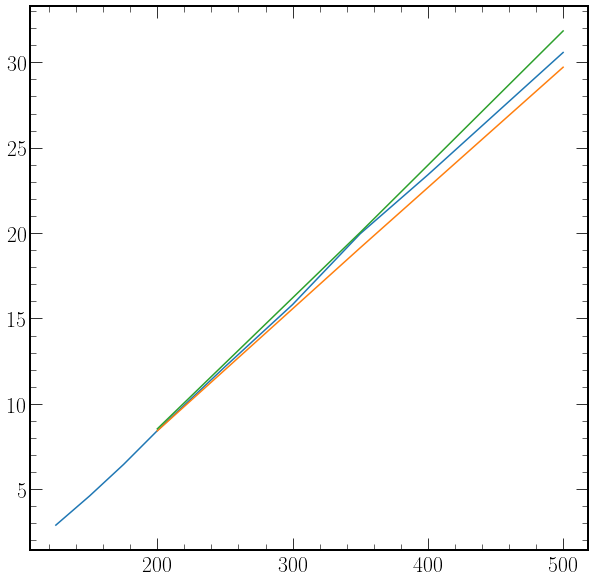

In [25]:
plt.plot(mass, stds)
plt.plot(massp5, stdsp5)
plt.plot(mass1, stds1)
curve_fit(linear, mass, stds)



In [31]:
30/500

0.06

In [146]:
sum_masses = []
for m in mass:
    std = df[(df.mass==m)& (df.dbs==0.04)& (df.SR2_nom==1)]['Weight'].sum()
    sum_masses.append(std)
sum_masses
mass

sum_masses_1 = []
mass1 = []
for m in mass:
    std = df[(df.mass==m)& (df.dbs==1.)& (df.SR2_nom==1)]['Weight']
    if std.shape[0]>0:
        std = std.sum()
        print(std)
        sum_masses_1.append(std)
        mass1.append(m)
        
        
sum_masses_p5 = []
mass1 = []
for m in mass:
    std = df[(df.mass==m)& (df.dbs==0.5)& (df.SR2_nom==1)]['Weight']
    if std.shape[0]>0:
        std = std.sum()
        print(std)
        sum_masses_p5.append(std)
        mass1.append(m)

853.8206763012603
144.0257332948218
24.529768275414618
422.37354842405796
68.65926433130781
11.216231782890734


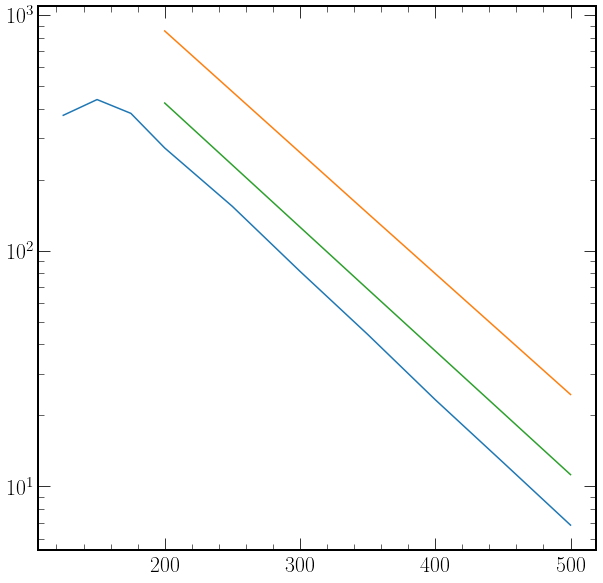

In [147]:
plt.plot(mass, sum_masses)
plt.plot(mass1, sum_masses_1)
plt.plot(mass1, sum_masses_p5)
plt.yscale('log')

In [120]:
names = np.unique(df['name'])
types = np.unique(df['type'])
name_dict = { t:np.unique(df[df['type']==t]['name']) for t in types}
types, name_dict

(array(['bck', 'data', 'sig'], dtype=object),
 {'bck': array(['ZToEE_M_120_200', 'ZToEE_M_200_400', 'ZToEE_M_400_800',
         'ZToEE_M_50_120', 'ZToEE_M_800_1400', 'ZToMuMu_M_120_200',
         'ZToMuMu_M_200_400', 'ZToMuMu_M_400_800', 'ZToMuMu_M_50_120',
         'ZToMuMu_M_800_1400', 'mc_santitop', 'mc_stop', 'mc_ttbar',
         'mc_ww', 'mc_wz', 'mc_zz'], dtype=object),
  'data': array(['data_el', 'data_mu'], dtype=object),
  'sig': array(['BFFZprimeToMuMu_M_125_dbs0p04', 'BFFZprimeToMuMu_M_150_dbs0p04',
         'BFFZprimeToMuMu_M_175_dbs0p04', 'BFFZprimeToMuMu_M_200_dbs0p04',
         'BFFZprimeToMuMu_M_200_dbs0p5', 'BFFZprimeToMuMu_M_200_dbs1p0',
         'BFFZprimeToMuMu_M_250_dbs0p04', 'BFFZprimeToMuMu_M_300_dbs0p04',
         'BFFZprimeToMuMu_M_350_dbs0p04', 'BFFZprimeToMuMu_M_350_dbs0p5',
         'BFFZprimeToMuMu_M_350_dbs1p0', 'BFFZprimeToMuMu_M_400_dbs0p04',
         'BFFZprimeToMuMu_M_450_dbs0p04', 'BFFZprimeToMuMu_M_500_dbs0p04',
         'BFFZprimeToMuMu_M_500_dbs0p5

In [121]:
bh_axis=bh.axis.Regular(139,105,800)
(lambda x: x.edges[::len(x)])(bh_axis)

array([105., 800.])

In [122]:
def fit_and_plot_from_df(top, bottom,  tdf, bh_axis=bh.axis.Regular(139,110,800), verbose=False, weight='Weight', label=""):
    y = tdf['DiLepMass'].to_numpy()
    weights = tdf[weight].to_numpy()
    limits = (lambda x: x.edges[::len(x)])(bh_axis)
    obs = zfit.Space("x", limits=limits)
    lognorm, data = fit_lognorm(y, weights, obs, verbose=verbose)
    sumW, sumW2 = np.sum(data.weights.numpy()), np.sum(data.weights.numpy()**2)
    std = sumW2**.5
    from uncertainties import ufloat
    sum_ufloat = ufloat(sumW, std)
                        
    #fill histogram
    hist = bh.Histogram(bh_axis, storage=bh.storage.Weight())
    hist.fill(data.value().numpy().reshape(-1), weight=data.weights.numpy())
    x = hist.axes[0].centers
    n_bins = len(x)
    plot_scaling = sumW / n_bins * obs.area()
    plot_scaling_unc = sum_ufloat * ufloat(1./ n_bins * obs.area(),0)
    top.errorbar(x, hist.values(), yerr=hist.variances()**.5, label=label, color='black',zorder=1)
    unc = lognorm.uncertainty(x) * plot_scaling_unc
    unc_plot(top, x, unc, label='fit {}'.format(label), fill_between=True, color='maroon',zorder=2)
    
    hist_unc = hist2unc(hist)
    unc_plot(bottom, x, unc/(hist.values()+1e-12), label='fit {}'.format(label), fill_between=True, color='maroon',zorder=2)
    unc_plot(bottom, x, hist_unc/(hist.values()+1e-12), label='data {}'.format(label), fill_between=True, color='black',zorder=1)
    bottom.plot(limits,[1,1])
    return {'lognorm':lognorm, 'sumW':sumW, 'std':std, 'unc':unc, 'x':x, 'hist_unc': hist_unc}

In [123]:
def fit_and_abcd(nJets,data_name, verbose=False):
    fig, axes = nratio_plot_template(nPlots=[1,1],rps = 2, figsize=[8,8])
    reg_keys = {'SR{}_{}':([0,0], r'$SR_b^{\mu\mu}$')}
    unp_pred = {}
    unp_hist = {}
    reg_dict = {}
    isData = "data" in data_name
    for name, ((i,j), region_text) in reg_keys.items():
        name = name.format(nJets, 'nom')
        print(name)
        
        top, bottom = axes[i][j]
        
        tdf = df[(df.name==data_name) & (df[name]==1)]
        label='{} {} Jet'.format(region_text,nJets)
        plot_dict = fit_and_plot_from_df(top, bottom, tdf, label=label, verbose=verbose)
        reg_dict[name] = plot_dict
        #top.set_yscale('log')
        #top.set_ylim(bottom=1e-4, top=1e5)
        top.legend()
        
        bottom.set_xlabel('DiLepMass [GeV]')
        top.set_ylabel('Count per 5 GeV')
        hep.cms.label(loc=0,ax=top,lumi=lumi,year=era, data=isData)
        bottom.set_ylim(0,2)
    return fig, reg_dict

In [124]:
nr.set_value(10)
alphar.set_value(15)

In [ ]:
500: 11

[]
SR1_nom
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class '__main__.DoubleCBError'>  params=[alphal, alphar, mu, nl, nr, sigma]] data=[<zfit.core.data.Data object at 0x7f27c7cc3f10>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00023 │ 955         │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value    at limit
------  -------  ----------
Nsig      20.58       False
alphal    1.388       False
alphar    1.565       False
mu        498.3       False
nl        2.543       False
nr        42.05       False
sigma        11       False


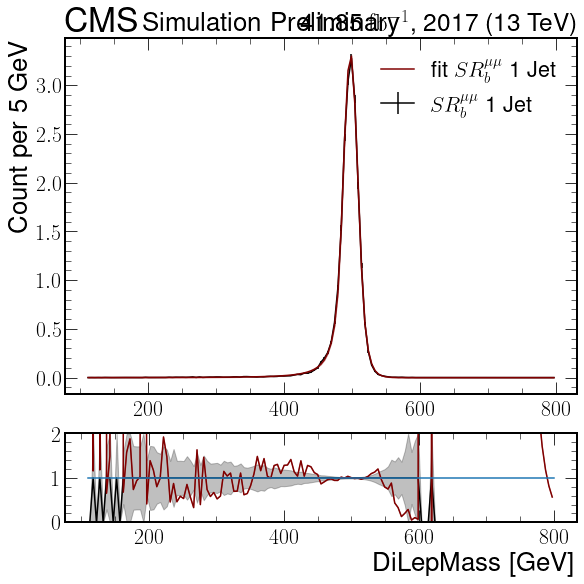

In [125]:
fig, reg_dict = fit_and_abcd(1,'BFFZprimeToMuMu_M_500_dbs0p04', verbose=True)

[]
SR1_nom
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class '__main__.DoubleCBError'>  params=[alphal, alphar, mu, nl, nr, sigma]] data=[<zfit.core.data.Data object at 0x7f27caacb9a0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.9e-05 │ -2198       │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value    at limit
------  -------  ----------
Nsig      929.6       False
alphal    1.249       False
alphar    1.606       False
mu        199.8       False
nl        2.795       False
nr        6.037       False
sigma      2.89       False


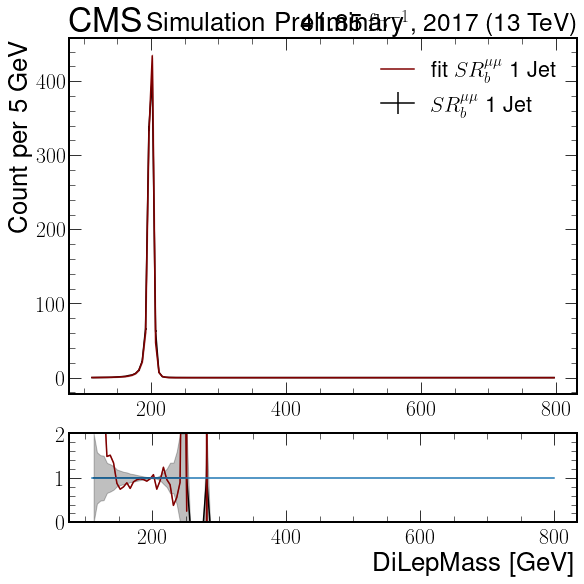

In [126]:
fig, reg_dict = fit_and_abcd(1,'BFFZprimeToMuMu_M_200_dbs0p04', verbose=True)

[]
SR2_nom
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class '__main__.DoubleCBError'>  params=[alphal, alphar, mu, nl, nr, sigma]] data=[<zfit.core.data.Data object at 0x7f27c79ddd60>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00022 │ 793.8       │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value    at limit
------  -------  ----------
Nsig      436.9       False
alphal    1.392       False
alphar    1.623       False
mu        149.9       False
nl        1.858       False
nr        7.128       False
sigma     1.992       False


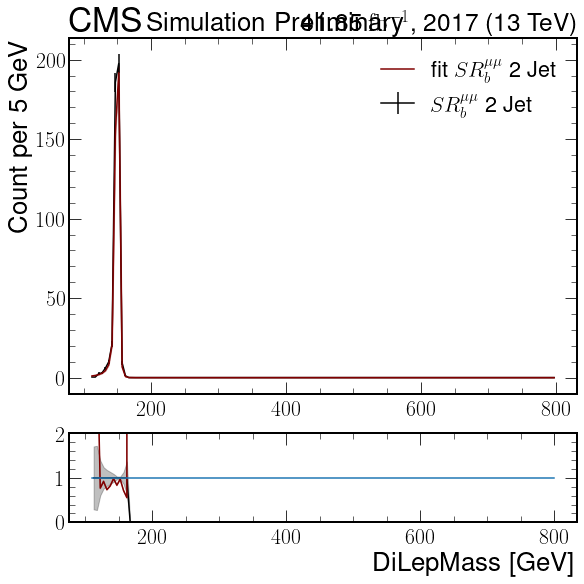

In [127]:
fig, reg_dict = fit_and_abcd(2,'BFFZprimeToMuMu_M_150_dbs0p04', verbose=True)

(array([ 0.0261814 , -2.12139535]),
 array([[ 1.13081670e-06, -3.20398063e-04],
        [-3.20398063e-04,  1.17793404e-01]]))

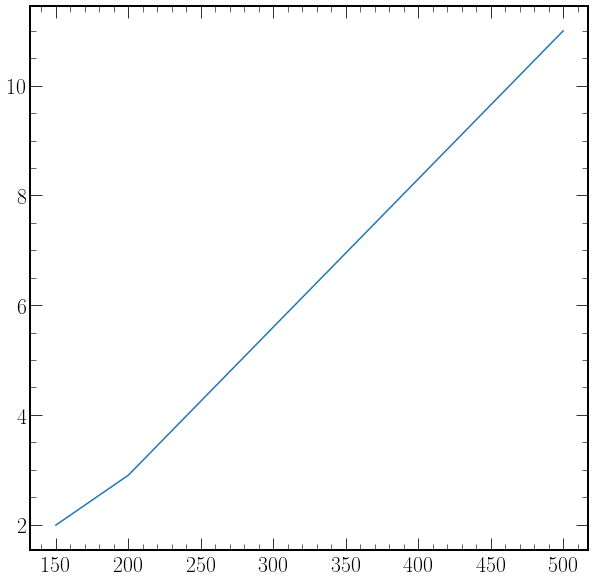

In [142]:
m = [500, 200, 150]
sigma = [ 11, 2.9, 1.99]
plt.plot(m, sigma)
curve_fit(linear,m,sigma)

In [47]:
reg_dict['SR2_nom']['lognorm'].normalization([105,800])

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([5.79938276])>

[]
SR1_nom


/home/ryan/Develop/Physics/bff_plotting_code_v3/env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ryan/Develop/Physics/bff_plotting_code_v3/env/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


InvalidArgumentError:  Check if pdf output contains any NaNs of Infs : Tensor had NaN values
	 [[node CheckNumerics (defined at /home/ryan/Develop/Physics/bff_plotting_code_v3/env/lib/python3.8/site-packages/zfit/z/wrapping_tf.py:71) ]] [Op:__inference__loss_func_watched_14130]

Errors may have originated from an input operation.
Input Source operations connected to node CheckNumerics:
 StatefulPartitionedCall_1 (defined at /home/ryan/Develop/Physics/bff_plotting_code_v3/env/lib/python3.8/site-packages/zfit/z/zextension.py:214)	
 VerifyFinite/CheckNumerics (defined at /home/ryan/Develop/Physics/bff_plotting_code_v3/env/lib/python3.8/site-packages/zfit/core/integration.py:89)

Function call stack:
_loss_func_watched


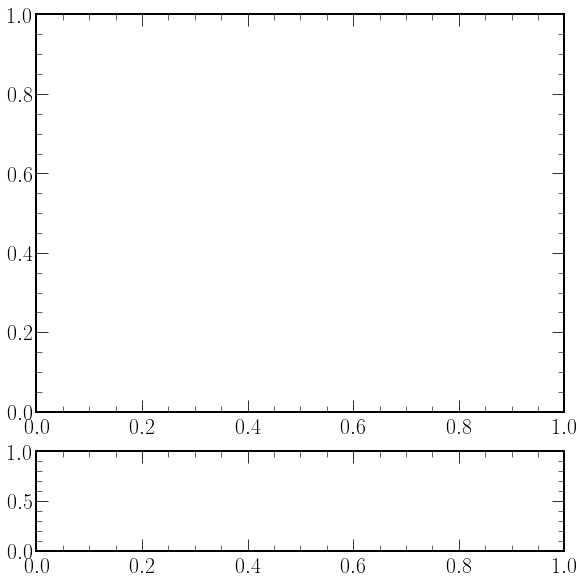

In [30]:
fig, reg_1_MC = fit_and_abcd(1, 'bck')
fig.savefig('fits/stat_lognorm_fit_1J_mc_{}.pdf'.format(era))
summarize_fits(reg_1_MC, "1_jet_MC_{}".format(era))

[]
SR2_nom
FitResult of
<UnbinnedNLL model=[<zfit.<class '__main__.LogNormPDF'>  params=[mean, sigma, theta]] data=[<zfit.core.data.Data object at 0x7fc655bded60>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00071 │ 245         │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value    minuit_hesse    at limit
------  -------  --------------  ----------
mean      138.4     +/-      21       False
sigma    0.4297     +/-   0.043       False
theta     23.38     +/-      27       False
CR20_nom
FitResult of
<UnbinnedNLL model=[<zfit.<class '__main__.LogNormPDF'>  params=[mean, sigma, theta]] data=[<zfit.core.data.Data object at 0x7fc6499d0d00>] constraints=[]> 
with
<Minuit Minuit tol=0.001>


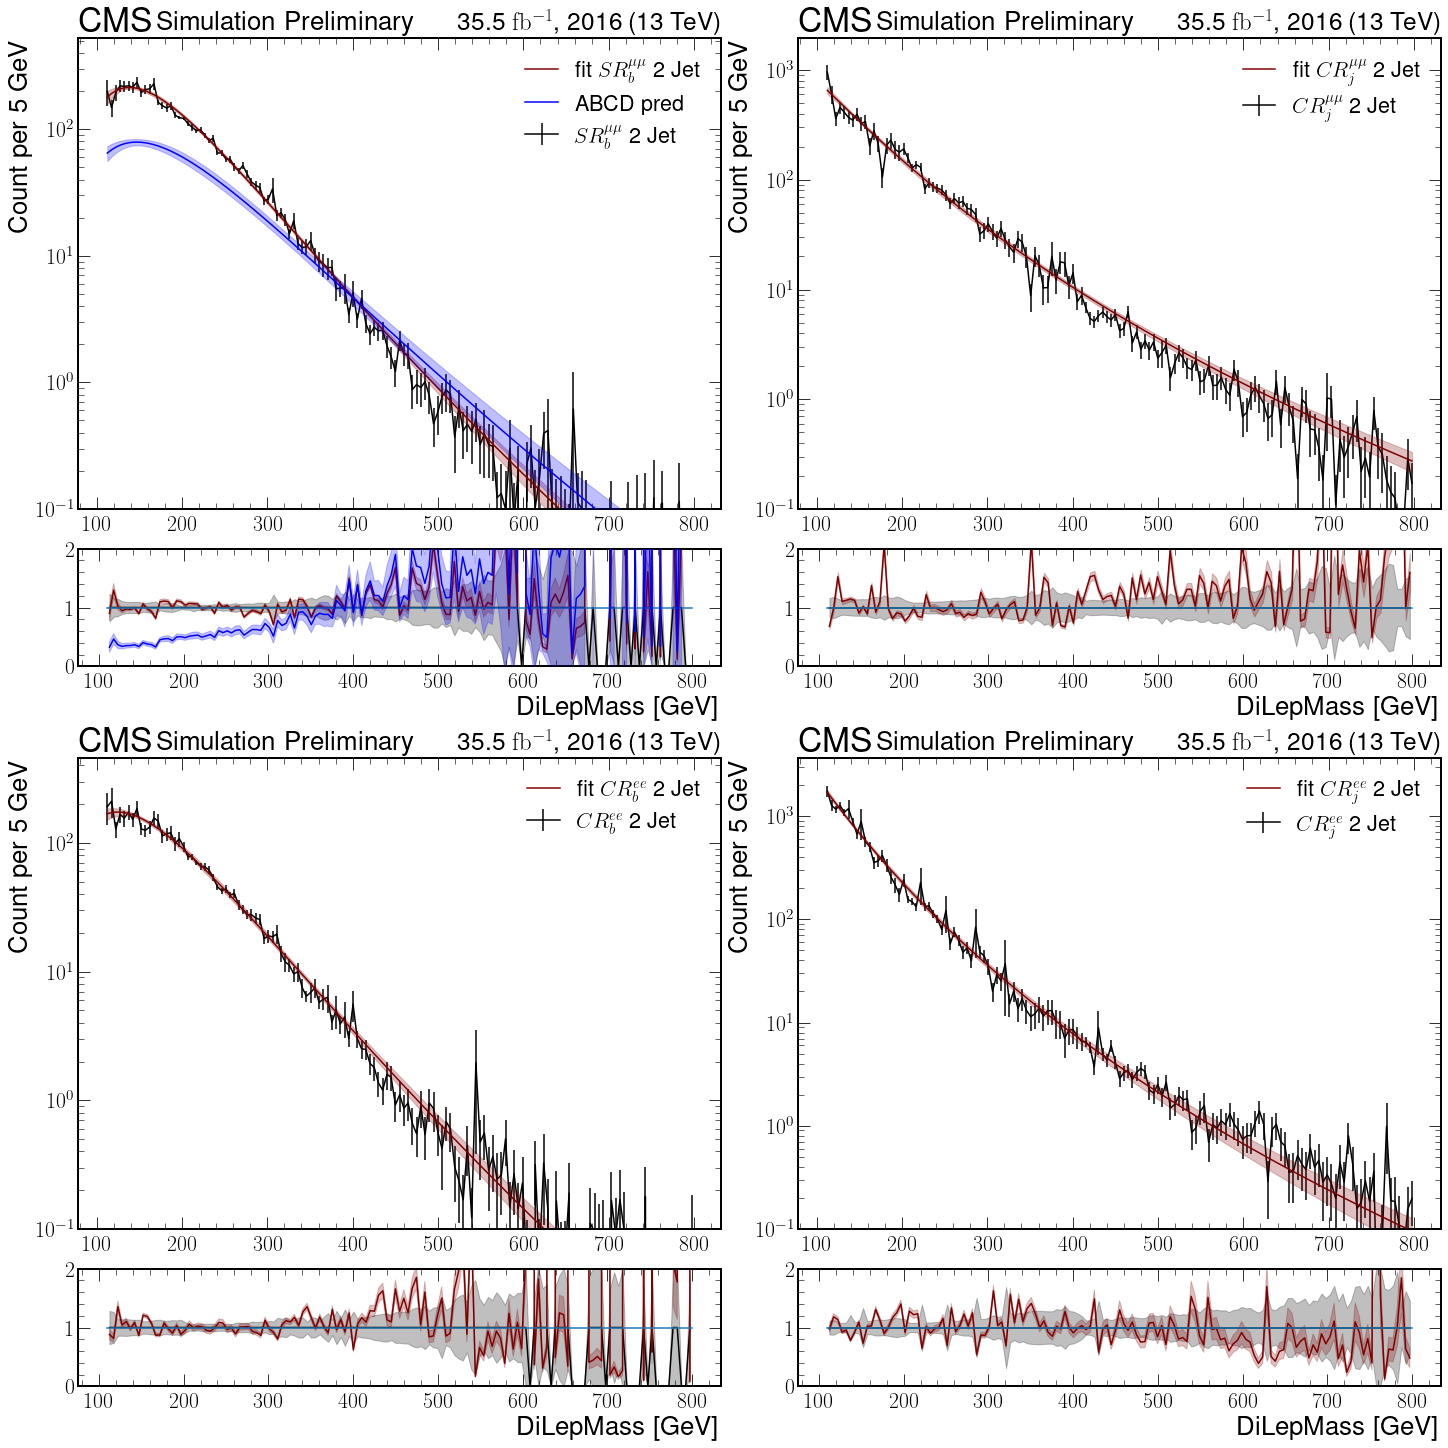

In [42]:
fig, reg_2_MC = fit_and_abcd(2, 'bck', verbose=True)
fig.savefig('fits/stat_lognorm_fit_2J_mc_{}.pdf'.format(era))
summarize_fits(reg_2_MC, "2_jet_MC_{}".format(era))

[]
SR1_nom
CR10_nom
CR13_nom
CR14_nom


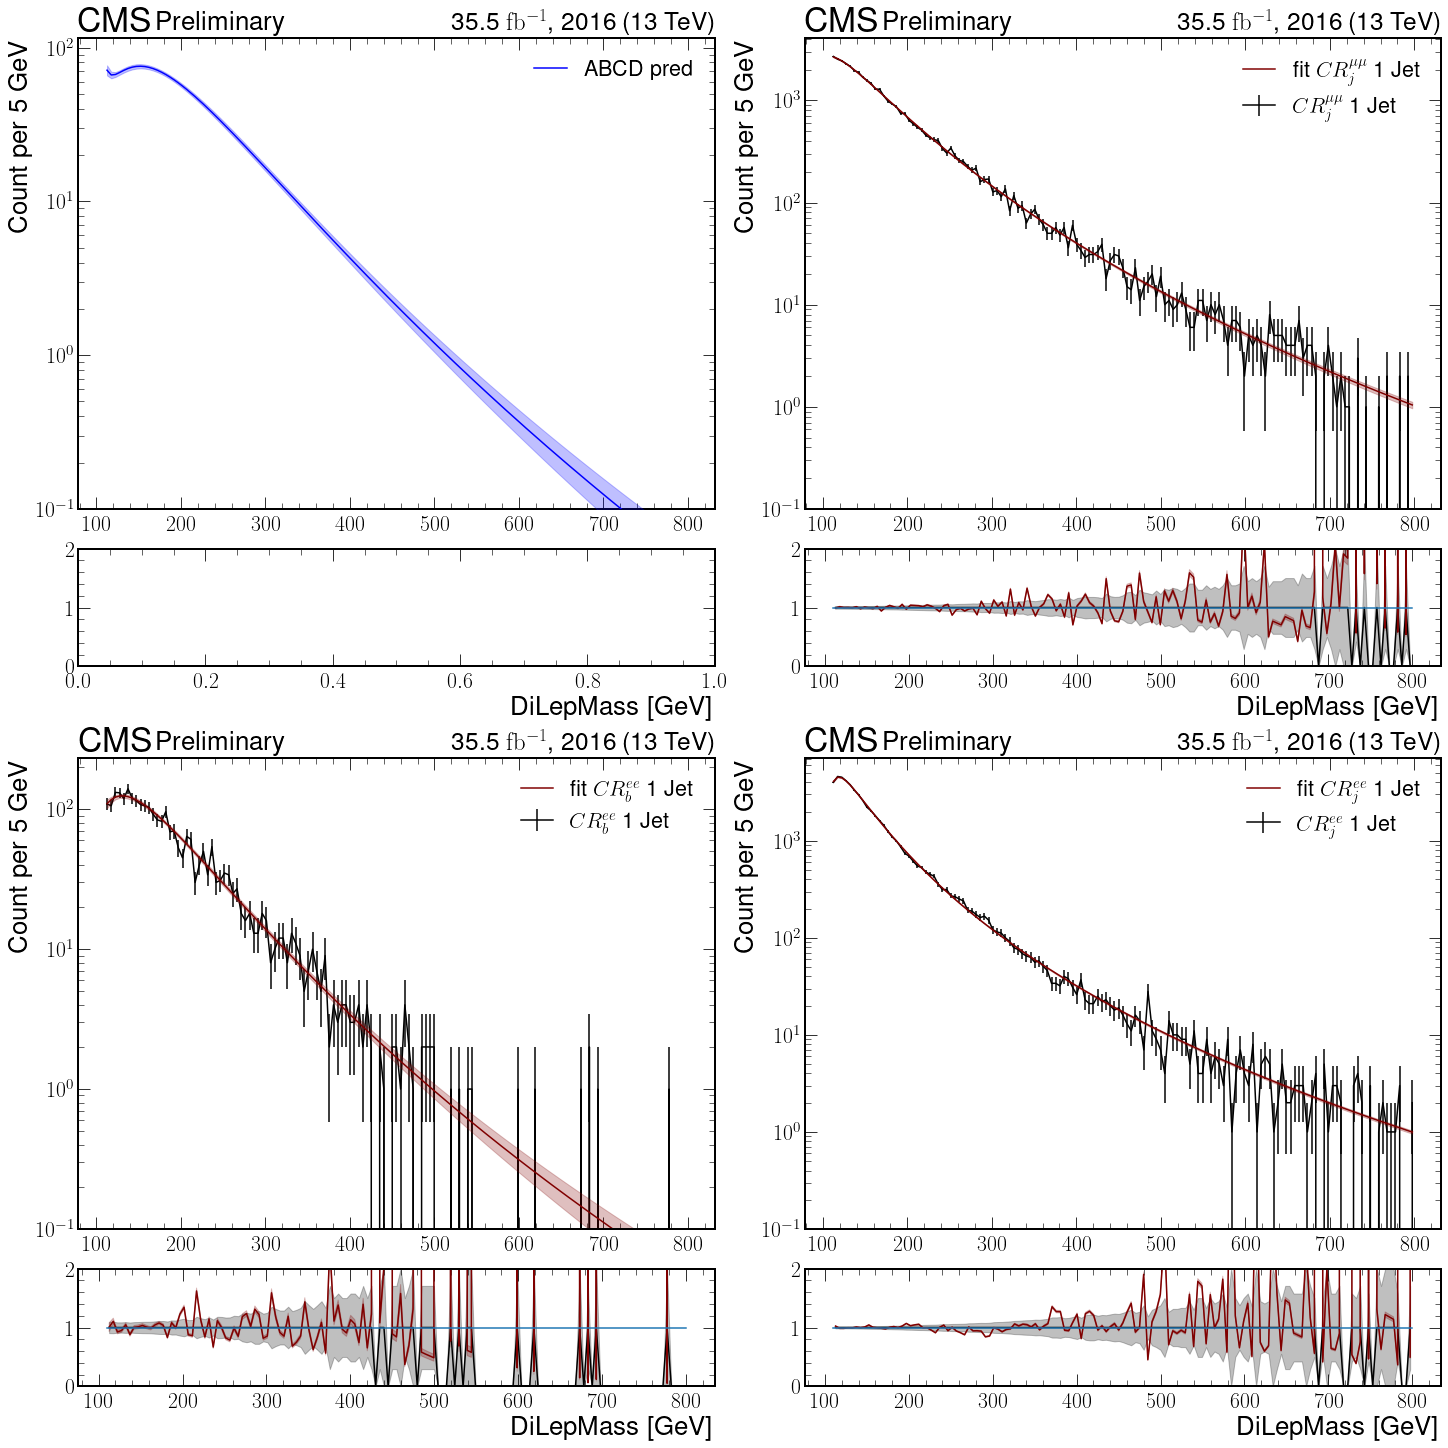

In [43]:
fig, reg_1_data = fit_and_abcd(1, 'data')
fig.savefig('fits/stat_lognorm_fit_1J_data_{}.pdf'.format(era))
summarize_fits(reg_1_data, "1_jet_data_{}".format(era))

[]
SR2_nom
CR20_nom
CR23_nom
CR24_nom


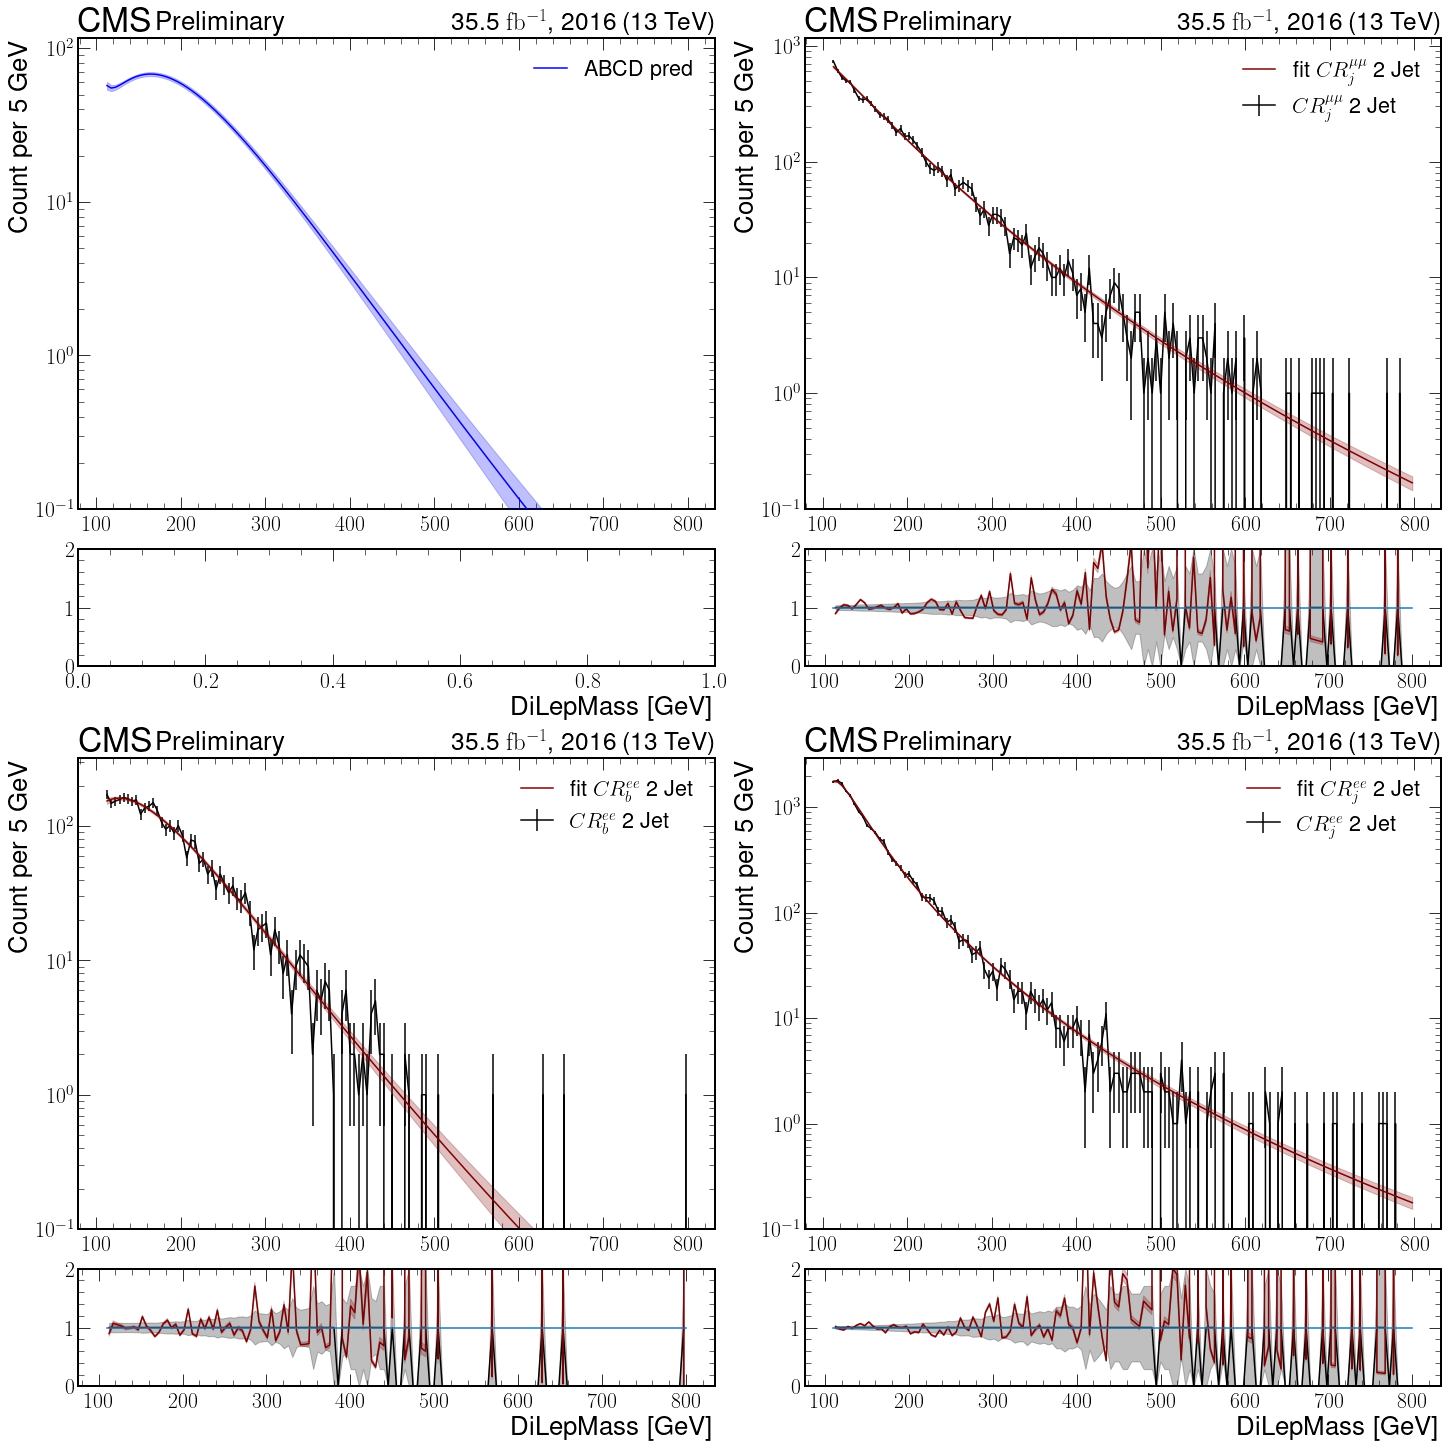

In [44]:
fig, reg_2_data =fit_and_abcd(2, 'data')
fig.savefig('fits/stat_lognorm_fit_2J_data_{}.pdf'.format(era))
summarize_fits(reg_2_data, "2_jet_data_{}".format(era))

In [45]:
def comp_plots(reg_dict,reg_data_dic, nJets):
    fig, axes = nratio_plot_template(nPlots=[2,2],rps = 2, figsize=[20,20])
    reg_keys = {'SR{}_{}':([0,0], r'$SR_b^{\mu\mu}$'),
    'CR{}0_{}':([1,0], r'$CR_j^{\mu\mu}$'),
    'CR{}3_{}':([0,1], r'$CR_b^{ee}$'),
    'CR{}4_{}':([1,1], r'$CR_j^{ee}$')}
    for name, ((i,j), region_text) in reg_keys.items():
        name = name.format(nJets, 'nom')
        print(name)
        x = reg_dict[name]['x']
        top, bottom = axes[i][j]

        label='{} {} Jet'.format(region_text,nJets)
        if not("SR" in name): 
            unc_plot(top, x, reg_data_dic[name]['unc'], label='data fit {}'.format(region_text), fill_between=True, color='blue',zorder=2)    
            unc_plot(bottom, x, reg_data_dic[name]['unc']/vunc2nom(reg_dict[name]['unc']), label='data fit {}'.format(region_text), fill_between=True, color='blue',zorder=2)    
        
        unc_plot(top, x, reg_dict[name]['unc'], label='MC fit {}'.format(region_text), fill_between=True, color='maroon',zorder=2) 
        unc_plot(bottom, x, reg_dict[name]['unc']/vunc2nom(reg_dict[name]['unc']), label='data fit {}'.format(region_text), fill_between=True, color='maroon',zorder=1)    
        if ("SR" in name): 
            unc_plot(top, x, reg_data_dic['abcd'], label='data ABCD {}'.format(region_text), fill_between=True, color='blue',zorder=2)  
            unc_plot(top, x, reg_dict['abcd'], label='mc ABCD {}'.format(region_text), fill_between=True, color='green',zorder=2)  
            unc_plot(bottom, x, reg_data_dic['abcd']/vunc2nom(reg_dict[name]['unc']), label='data ABCD {}'.format(region_text), fill_between=True, color='blue',zorder=2)  
            unc_plot(bottom, x, reg_dict['abcd']/vunc2nom(reg_dict[name]['unc']), label='mc ABCD {}'.format(region_text), fill_between=True, color='green',zorder=2)   
            
            unc_plot(top, x, reg_dict[name]['hist_unc'], label='MC {}'.format(region_text), fill_between=False, color='purple',zorder=0)  
            unc_plot(bottom, x, reg_dict[name]['hist_unc']/vunc2nom(reg_dict[name]['unc']), label='MC {}'.format(region_text), fill_between=False, color='purple',zorder=0)  
            
        top.set_yscale('log')
        top.set_ylim(bottom=1e-1)
        top.legend()
        bottom.set_xlabel('DiLepMass [GeV]')
        top.set_ylabel('Count per 5 GeV')
        hep.cms.label(loc=0,ax=top,lumi=lumi,year=era)
        bottom.set_ylim(0,2)
    return fig

[]
SR1_nom
CR10_nom
CR13_nom
CR14_nom


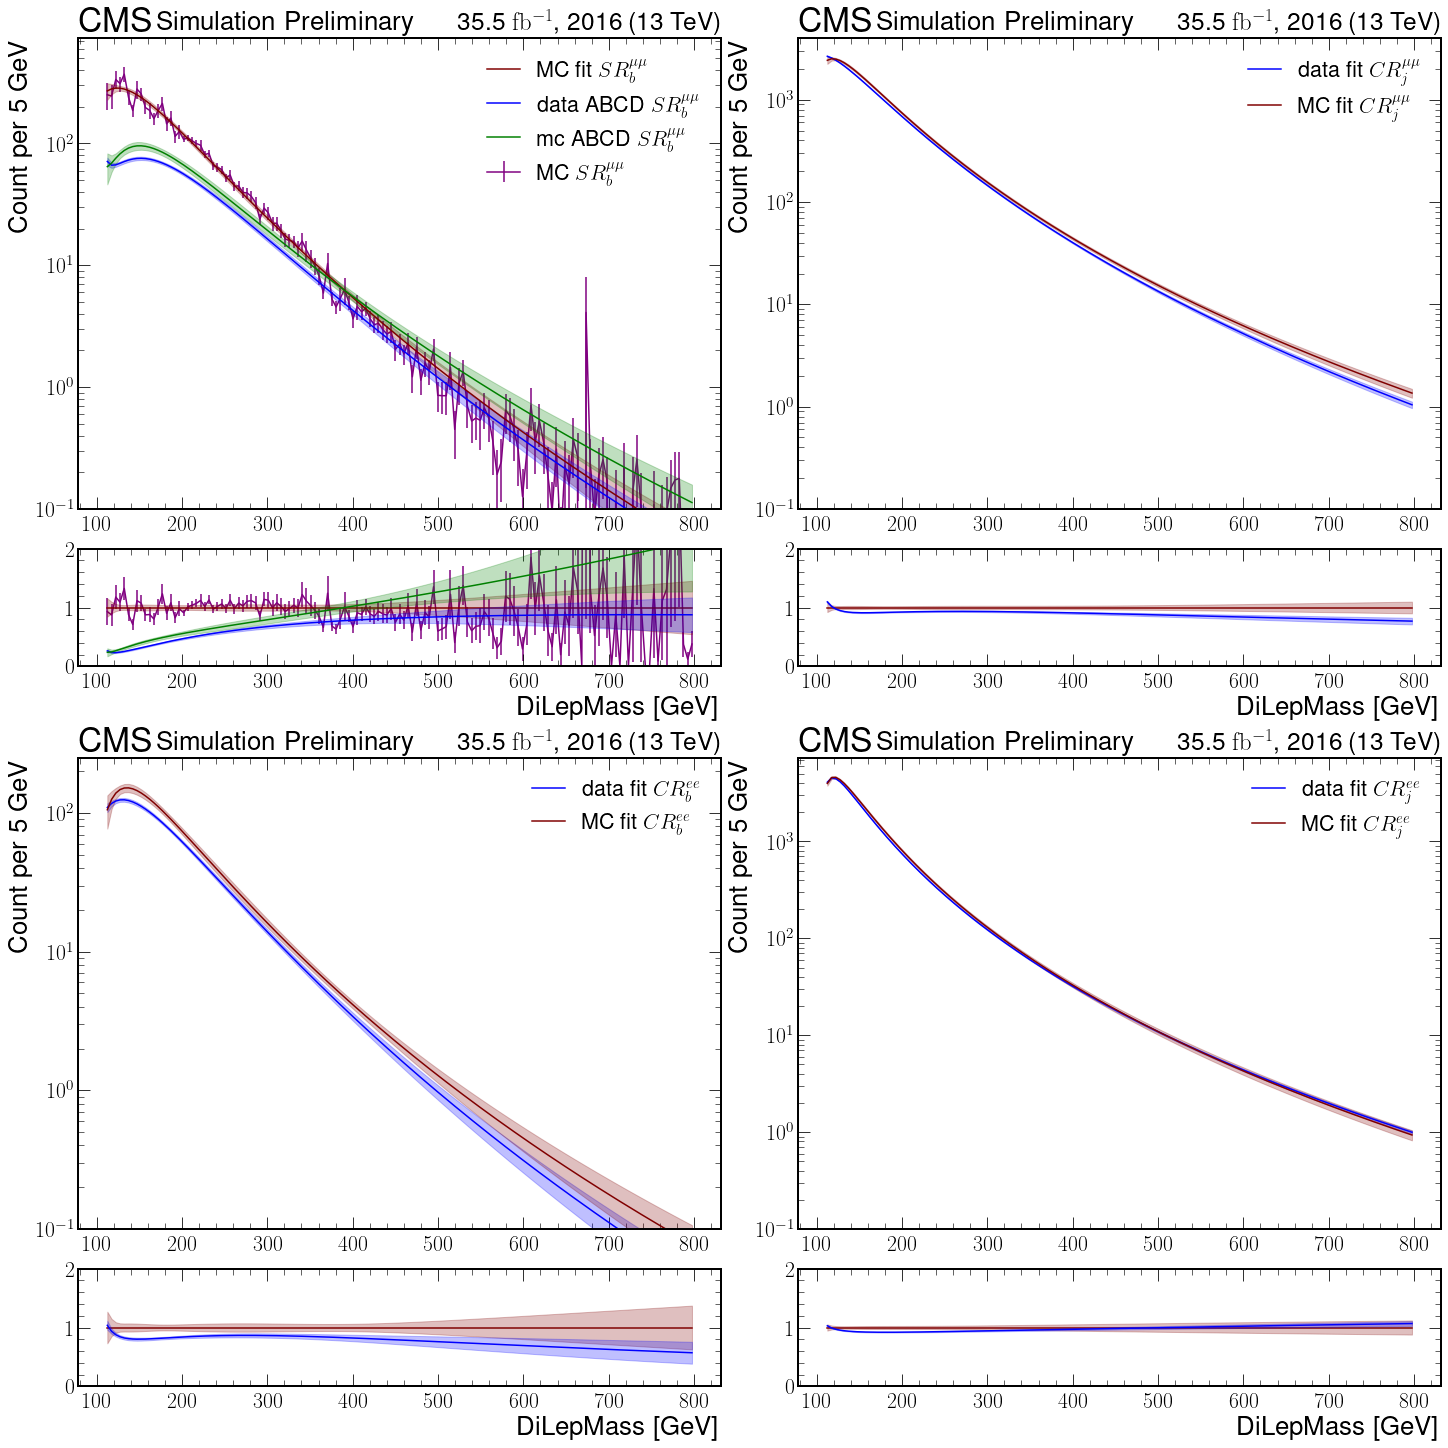

In [46]:
fig = comp_plots(reg_1_MC,reg_1_data, 1)
fig.savefig('fits/fit_comparision_1_{}.pdf'.format(era))

[]
SR2_nom
CR20_nom
CR23_nom
CR24_nom


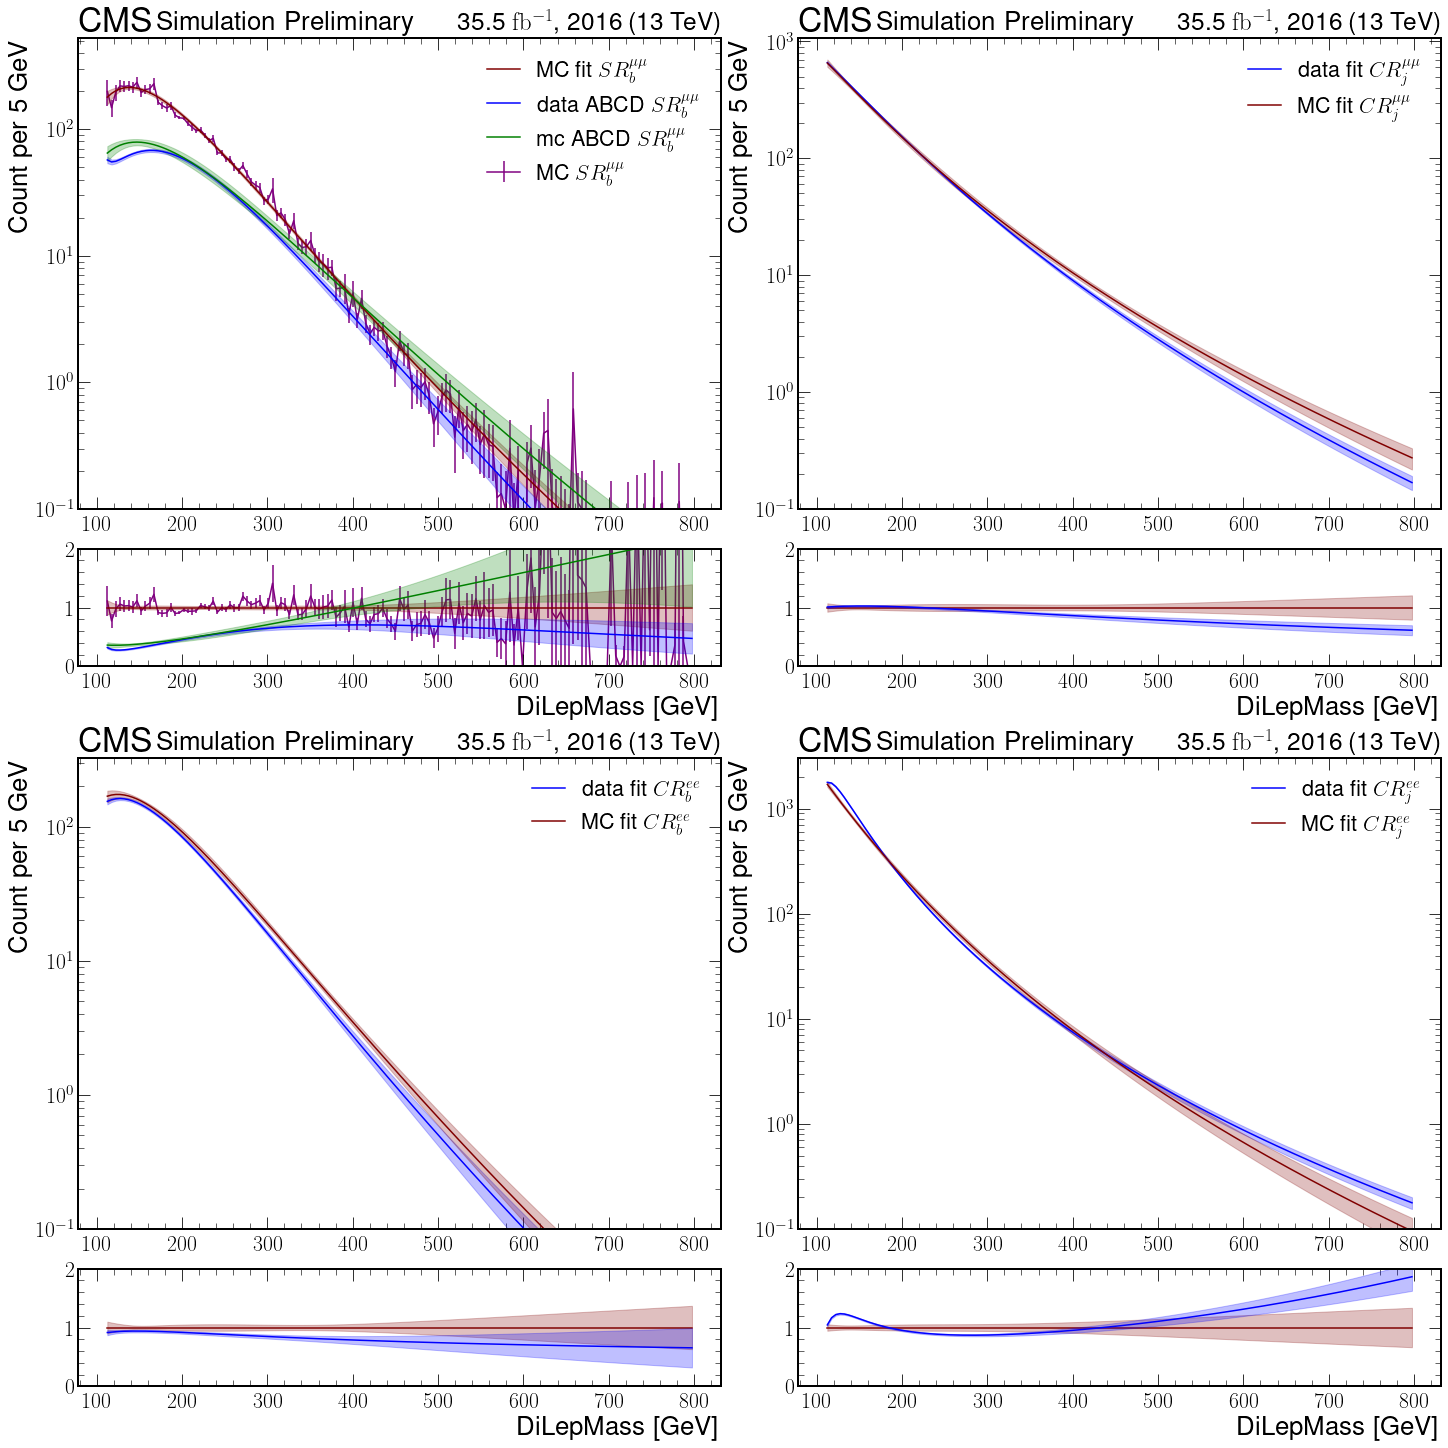

In [47]:
fig = comp_plots(reg_2_MC,reg_2_data, 2)
fig.savefig('fits/fit_comparision_2_{}.pdf'.format(era))

In [48]:
for reg in reg_2_MC:
    print(reg_2_MC[reg]['lognorm'].params)

OrderedDict([('mean', <zfit.Parameter 'mean' floating=True value=37.54>), ('sigma', <zfit.Parameter 'sigma' floating=True value=0.8504>), ('theta', <zfit.Parameter 'theta' floating=True value=95.8>)])
OrderedDict([('mean', <zfit.Parameter 'mean' floating=True value=37.54>), ('sigma', <zfit.Parameter 'sigma' floating=True value=0.8504>), ('theta', <zfit.Parameter 'theta' floating=True value=95.8>)])
OrderedDict([('mean', <zfit.Parameter 'mean' floating=True value=37.54>), ('sigma', <zfit.Parameter 'sigma' floating=True value=0.8504>), ('theta', <zfit.Parameter 'theta' floating=True value=95.8>)])
OrderedDict([('mean', <zfit.Parameter 'mean' floating=True value=37.54>), ('sigma', <zfit.Parameter 'sigma' floating=True value=0.8504>), ('theta', <zfit.Parameter 'theta' floating=True value=95.8>)])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices